In [10]:
import copy
import csv
import cv2
import glob
import os
import shutil
import time
from collections import Counter
from datetime import timedelta
import shortuuid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from torchvision import models, transforms

TRAIN_DATA_DIR = "data/TrainData-C2"
TRAIN_DATA_ANN_FILE = TRAIN_DATA_DIR + "/TrainAnnotations.csv"
TRAIN_DATA_AUGMENTED_DIR = "data/TrainData-C2_augmented"
TRAIN_DATA_AUGMENTED_ANN_FILE = TRAIN_DATA_AUGMENTED_DIR + "/TrainAnnotations.csv"

TRAIN_DATA_PATCHES_DIR      = "data/TrainData-C2_augmented_patches/"
TRAIN_DATA_PATCHES_ANN_FILE = "data/TrainData-C2_augmented_patches/TrainAnnotations.csv"

TEST_DATA_DIR         = "data/TestData/"
TEST_DATA_PATCHES_DIR = "data/TestData_patches/"

## Enable GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Augment data
Because the training dataset is unbalanced, augment the data set by generating
new images for the lower numbered samples.

In [11]:
DESIRED_CLASS_SAMPLE_COUNT = 500
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
PATCH_ROWS = 5
PATCH_COLUMNS = 5


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data():
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    os.mkdir(TRAIN_DATA_AUGMENTED_DIR)
    
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = DESIRED_CLASS_SAMPLE_COUNT - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(TRAIN_DATA_DIR + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(TRAIN_DATA_AUGMENTED_DIR, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    balanced_df.to_csv(TRAIN_DATA_AUGMENTED_ANN_FILE, index=False)
    
    # Copy images from original training data
    for file in glob.glob(TRAIN_DATA_DIR + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(TRAIN_DATA_AUGMENTED_DIR, os.path.basename(file)))
    
    print('Done.')


def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations_df(df, rows, cols):
    patches_ann = {}
    
    for ind in df.index: 
        file_name = df['file_name'][ind]
        annotation = df['annotation'][ind]
        
        for i in range(0, rows):
            for j in range(0, cols):
                patch_name = file_name.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = annotation
    
    return pd.DataFrame.from_records([(k, v) for k, v in patches_ann.items()], 
                                     columns=['file_name', 'annotation'])


### Run data augmentation

This only needs to be performed once. If you need to run this again, delete the `data/TrainData-C2_augmented` directory.

In [12]:
if os.path.exists(TRAIN_DATA_AUGMENTED_DIR):
    print("Augmented data already exists. Skipping.")
else:
    print("Balancing data sets...")
    augment_data()
    
    print("Generating patch files...")
    generate_patch_files(TRAIN_DATA_AUGMENTED_DIR, TRAIN_DATA_PATCHES_DIR, PATCH_ROWS, PATCH_COLUMNS)
    
    image_df = pd.read_csv(TRAIN_DATA_AUGMENTED_ANN_FILE)
    
    print("Generating patch annotations...")
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.to_csv(TRAIN_DATA_PATCHES_ANN_FILE, index=False)
    
    print("Done.")

Balancing data sets...
Creating 12 images for class 0
Creating 171 images for class 1
Creating 370 images for class 2
Creating 369 images for class 3
Creating 303 images for class 4
Done.
Generating patch files...
Generating patch annotations...
Done.


In [14]:
image_df = pd.read_csv(TRAIN_DATA_AUGMENTED_ANN_FILE)
    
print("Generating patch annotations...")
patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
patch_annotations_df.to_csv(TRAIN_DATA_PATCHES_ANN_FILE, index=False)
print("Done.")

Generating patch annotations...
Done.


## Datasets

Given a directory of images and a CSV file of annotations, this defines a PyTorch Dataset which will load an image from disk and apply all configure transformations and return a tuple containing the image and label.


In [15]:
class SoybeanDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data_path, ann_df, transforms=None):
        """
        Args:
            data_path (string): path to images
            ann_df (string): pandas data frame containing file names and annotations
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_path = data_path
        
        self.data = ann_df
        self.labels = np.asarray(self.data.iloc[:, 1])
        
        self.transforms = transforms

    def __getitem__(self, index):
        image_label = int(self.labels[index])
        img_path = os.path.join(self.data_path, self.data.file_name[index])
        img = Image.open(img_path)
        
        # Transform image
        if self.transforms is not None:
            img = self.transforms(img)
            
        # Return image and the label
        return (img, image_label)

    def __len__(self):
        return self.data.shape[0]


class SoybeanTestDatasetFolder(torch.utils.data.IterableDataset):
    def __init__(self, data_path, transforms=None):
        """
        Args:
            data_path (string): path to images
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_path = data_path
        self.transforms = transforms
        
        self.images = []
        
        for root, _, fnames in sorted(os.walk(data_path, followlinks=True)):
            for fname in sorted(fnames):
                path = fname
                if is_image_file(path):
                    self.images.append(path)

                                       
    def image_gen(self):
        for i in self.images:
            img_path = os.path.join(self.data_path, i)
            img = Image.open(img_path)
        
            # Transform image
            if self.transforms is not None:
                img = self.transforms(img)
                
            yield img
            

    def __iter__(self):
        return iter(self.image_gen())

    
    def __len__(self):
        return len(self.images)
    


class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_dataset, train_sampler=None,
                 val_dataset=None, val_sampler=None, 
                 test_dataset=None, test_sampler=None):
        self.class_weights = class_weights
        self.train_dataset = train_dataset
        self.train_sampler = train_sampler
        self.val_dataset   = val_dataset
        self.val_sampler   = val_sampler
        self.test_dataset  = test_dataset
        self.test_sampler  = test_sampler


def compute_class_weights(df, y_col):
    """
    Returns a list of class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy(dtype=np.int32).flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return torch.tensor(weights, dtype=torch.float32).to(device)
    


### Common image transformations
These images transformations will apply to both train and validation data.

In [41]:
class SamplewiseCenterNormalize(object):

    def __init__(self):
        pass
    
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        
        return torch.div(torch.add(tensor, torch.mul(torch.mean(tensor), -1)), torch.std(tensor) + 1e-6)
        

    def __repr__(self):
        return self.__class__.__name__



DATA_TRANSFORMS = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
    #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), shear=10, scale=(1.0, 1.2)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #transforms.RandomCrop(size=(480,640)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # SamplewiseCenterNormalize()

    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

TEST_DATA_TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # SamplewiseCenterNormalize()
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Train 0.80/Val 0.20 Split

In [42]:
def group_1():
    
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_DATA_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Computing class weights...")
    class_weights = compute_class_weights(ann_df, 'annotation')
    
    print("Splitting data into training and validation sets...")
    train_df, valid_df = train_test_split(ann_df,
                                          train_size=0.80,
                                          random_state=138,
                                          shuffle=True,
                                          stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    dataset = SoybeanDataset(TRAIN_DATA_PATCHES_DIR, ann_df, transforms=DATA_TRANSFORMS)
    test_dataset  = SoybeanTestDatasetFolder(TEST_DATA_PATCHES_DIR, transforms=TEST_DATA_TRANSFORMS)
    
    train_sampler = torch.utils.data.SubsetRandomSampler(list(train_df.index))
    valid_sampler = torch.utils.data.SubsetRandomSampler(list(valid_df.index))
        
    return SoybeanDataGroup(class_weights, dataset, train_sampler, dataset, valid_sampler, test_dataset, None)

### Train 0.56/Val 0.24/Test 0.20 Split
The `TrainData-C2` data is split in the following way:
1. Randomly split with stratification into 80%/20% train and test data sets
2. Randomly split with stratification the train set into 70%/30% training/validation sets

This yields:
* training set that is `0.80 * 0.70 = 0.56` of the entire `TrainData-C2` dataset
* validation set that is `0.80 * 0.30 = 0.24` of the entire `TrainData-C2` dataset
* test set that is `0.20` of the entire `TrainData-C2` dataset
where each of the data sets have the same class label distribution which should be the same
distribution as the original `TrainData-C2` data.

In [18]:
def group_2():
    
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Computing class weights...")
    class_weights = compute_class_weights(ann_df, 'annotation')
    
    print("Splitting data into training, validation, and test sets...")
    training_df, test_df = train_test_split(ann_df,
                                            train_size=0.80,
                                            random_state=138,
                                            shuffle=True,
                                            stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())
    
    train_df, val_df = train_test_split(training_df,
                                        train_size=0.70,
                                        random_state=128,
                                        shuffle=True,
                                        stratify=training_df[['annotation']].to_numpy(dtype=np.int32).flatten())
    
    # Generate split dataframes
    train_patches_df = generate_patch_annotations_df(train_df, PATCH_ROWS, PATCH_COLUMNS)
    val_patches_df = generate_patch_annotations_df(val_df, PATCH_ROWS, PATCH_COLUMNS)
    test_patches_df = generate_patch_annotations_df(test_df, PATCH_ROWS, PATCH_COLUMNS)

    train_dataset = SoybeanDataset(TRAIN_DATA_PATCHES_DIR, train_patches_df, transforms=DATA_TRANSFORMS)
    val_dataset = SoybeanDataset(TRAIN_DATA_PATCHES_DIR, train_patches_df, transforms=DATA_TRANSFORMS)
    test_dataset = SoybeanDataset(TRAIN_DATA_PATCHES_DIR, test_patches_df, transforms=TEST_DATA_TRANSFORMS)
    
    return SoybeanDataGroup(class_weights, train_dataset, None, val_dataset, None, test_dataset, None)

### Train 100%

Train with all the data in the `TrainData-C2` dataset 

In [19]:
def group_3():
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_DATA_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Computing class weights...")
    class_weights = compute_class_weights(ann_df, 'annotation')
    print(class_weights)

    train_dataset = SoybeanDataset(TRAIN_DATA_PATCHES_DIR, ann_df, transforms=DATA_TRANSFORMS)
    test_dataset  = SoybeanTestDatasetFolder(TEST_DATA_PATCHES_DIR, transforms=TEST_DATA_TRANSFORMS)
    
    return SoybeanDataGroup(class_weights, train_dataset, None, None, None, test_dataset, None)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [20]:
def get_model(n1, d1, n2, d2):
    model = models.vgg16(pretrained=True)

    # Freeze training for all layers
    for param in model.features.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d((1,1))
    
    # Replace the VGG16 classifier with a custom classifier for soybean wilting 
    model.classifier = nn.Sequential(
        nn.Linear(512 * 1 * 1, n1, bias=True),
        nn.ReLU(),
        nn.Dropout(p=d1),
        nn.Linear(n1, n2, bias=True),
        nn.ReLU(),
        nn.Dropout(p=d2),
        nn.Linear(n2, 5, bias=True)
    )
    
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [21]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25):
    """
    Trains the specified neural network model
    
    Args:
        model:         - neural network model to train
        criterion:     - loss function
        optimizer:     - gradient descent optimization algorithm
        dataloaders:   - dict of DataLoaders for training and validation data
        dataset_sizes: - dict of sizes of datasets
        num_epochs:    - number of epochs to train model
    Returns:
        model   - trained model with weights from the epoch with the best validation accuracy
        history - dict of training and validation loss and accuracy for all epochs
    """
    since = time.time()
    
    # summary(model, input_size=(3, 224, 224))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train': {'loss': [], 'acc': []}}
    phases = ['train']
    if ('val' in dataloaders and dataloaders['val'] is not None):
        phases += ['val']
        history['val'] = {'loss': [], 'acc': []}
    
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and optionally, a validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            phase_start = time.time()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:               
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        nn.utils.clip_grad_norm_(model.parameters(), 1)
                        nn.utils.clip_grad_value_(model.parameters(), 0.5)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels.data.view_as(preds)).cpu().sum()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            
            phase_end = time.time()
            phase_elapsed = phase_end - phase_start

            print('{} {} loss: {:.4f} accuracy: {:.4f}'.format(
                phase, str(timedelta(seconds=phase_elapsed)), epoch_loss, epoch_acc))

            # deep copy the model
            if ('val' not in phases or phase == 'val') and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_end = time.time()
        epoch_elapsed = epoch_end - epoch_start
        print('Elapsed time: {}'.format(str(timedelta(seconds=epoch_elapsed))))
        
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

## Train models

In [39]:
BATCH_SIZE = 32

def get_sample_count(dataset, sampler):
    if (sampler is not None):
        return len(sampler)
    elif (dataset is not None):
        return len(dataset)
    else:
        return None
    

def train(model, group, num_epochs=20):
    criterion = nn.CrossEntropyLoss(weight=group.class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-07)
    
    dataloaders = {
        'train': torch.utils.data.DataLoader(group.train_dataset, 
                                             sampler=group.train_sampler,
                                             batch_size=BATCH_SIZE,
                                             pin_memory=True, 
                                             num_workers=16), 
        'val': None if group.val_dataset is None else torch.utils.data.DataLoader(group.val_dataset,
                                                                                  sampler=group.val_sampler,
                                                                                  batch_size=BATCH_SIZE,
                                                                                  pin_memory=True,
                                                                                  num_workers=16)
    }

    dataset_sizes = {
        'train': get_sample_count(group.train_dataset, group.train_sampler), 
        'val': get_sample_count(group.val_dataset, group.val_sampler) 
    }

    model_trained, history = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)
    
    
    return model_trained, history


@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds


def plot_metrics(model, history):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    # Create count of the number of epochs
    epoch_count = range(1, len(history['train']['loss']) + 1)

    # Visualize loss history
    plt.plot(epoch_count, history['train']['loss'], 'g-')
    loss_legend = ['Training Loss']
    
    if ('val' in history and history['val'] is not None):
        plt.plot(epoch_count, history['val']['loss'], 'b-')
        loss_legend += ['Validation Loss']
        
    plt.legend(loss_legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    
    # Visualize accuracy history
    plt.plot(epoch_count, history['train']['acc'], 'g-')
    acc_legend = ['Training Accuracy']
    
    if ('val' in history and history['val'] is not None):
        plt.plot(epoch_count, history['val']['acc'], 'b-')
        acc_legend += ['Validation Accuracy']
    
    plt.legend(acc_legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show();
    
    # Training confusion matrix
    # train_preds = get_all_preds(model, dataloaders['train'])
    # train_labels = 
    
    # Validation confusion matrix
    #if (dataloaders['val'] is not None):
    #    val_preds = get_all_preds(model, dataloaders['val'])
     


def train_and_test(model, group, num_epochs=60):
    model_trained, history = train(model, group, num_epochs)
    
    # Plot history metrics
    plot_metrics(model_trained, history)
    
    # Classify test data
    return predict(model_trained, group)


def predict(model, group):
    test_loader = torch.utils.data.DataLoader(group.test_dataset, 
                                              sampler=group.test_sampler,
                                              batch_size=BATCH_SIZE,
                                              pin_memory=True,
                                              num_workers=0)
    predictions = torch.tensor([], dtype=torch.long).to(device)
    
    with torch.no_grad():
        for data in test_loader:
            if (type(data) is list):
                images = data[0].to(device)
            else:
                images = data.to(device)
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions = torch.cat((predictions, predicted))

    return predictions


def predict_whole_images(patch_predictions, rows, columns, csvfile):
    y_hat_test = patch_predictions.cpu().numpy()
    y_hat_patch_groups = np.split(y_hat_test, int(len(y_hat_test)/(rows * columns)))
    y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

    for k, v in sorted(Counter(y_hat_whole_images).items()): 
        print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
    for i in range(len(one_hots)):
        pred = y_hat_whole_images[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)

### Train and Test - Group 1

Reading annotations...
Computing class weights...
Splitting data into training and validation sets...
Epoch 0/14
----------
train 0:01:31.047673 loss: 0.9999 accuracy: 0.5798
val 0:00:22.976616 loss: 0.8906 accuracy: 0.6266
Elapsed time: 0:01:54.027989

Epoch 1/14
----------
train 0:01:31.029523 loss: 0.8842 accuracy: 0.6290
val 0:00:22.956835 loss: 0.8373 accuracy: 0.6527
Elapsed time: 0:01:53.990006

Epoch 2/14
----------
train 0:01:31.183172 loss: 0.8346 accuracy: 0.6546
val 0:00:22.928036 loss: 0.8232 accuracy: 0.6624
Elapsed time: 0:01:54.114830

Epoch 3/14
----------
train 0:01:31.189039 loss: 0.8088 accuracy: 0.6628
val 0:00:23.027358 loss: 0.7675 accuracy: 0.6804
Elapsed time: 0:01:54.220221

Epoch 4/14
----------
train 0:01:31.201439 loss: 0.7784 accuracy: 0.6758
val 0:00:22.986144 loss: 0.7903 accuracy: 0.6731
Elapsed time: 0:01:54.188936

Epoch 5/14
----------
train 0:01:31.142861 loss: 0.7612 accuracy: 0.6868
val 0:00:22.950353 loss: 0.7475 accuracy: 0.6938
Elapsed time: 0:

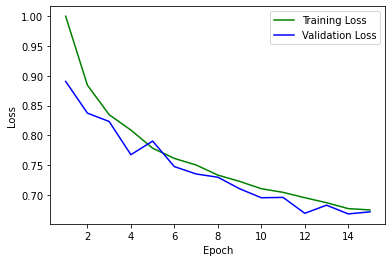

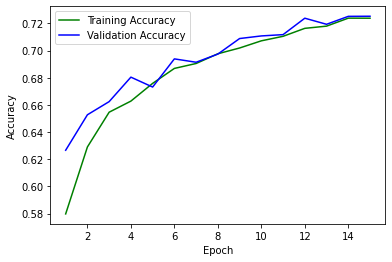

In [44]:
model = get_model(1024, 0.1, 128, 0.1).to(device)
y_hat_test = train_and_test(model, group_1(), num_epochs=15)
predict_whole_images(y_hat_test, 5, 5, 'predictions_c2_g1.csv')

### Train and Test - Group 2

Reading annotations...
Computing class weights...
Splitting data into training, validation, and test sets...
Epoch 0/2
----------
train 0:00:33.117606 loss: 1.3415 accuracy: 0.4840
val 0:00:32.493421 loss: 1.3690 accuracy: 0.5196
Elapsed time: 0:01:05.614094

Epoch 1/2
----------
train 0:00:33.513008 loss: 1.1747 accuracy: 0.5561
val 0:00:33.043106 loss: 1.3928 accuracy: 0.5430
Elapsed time: 0:01:06.558672

Epoch 2/2
----------
train 0:00:32.611749 loss: 1.1161 accuracy: 0.5735
val 0:00:32.351024 loss: 1.3231 accuracy: 0.5671
Elapsed time: 0:01:04.966130

Training complete in 3m 17s
Best acc: 0.567115


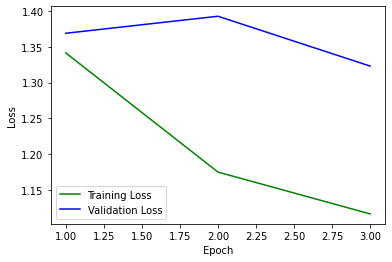

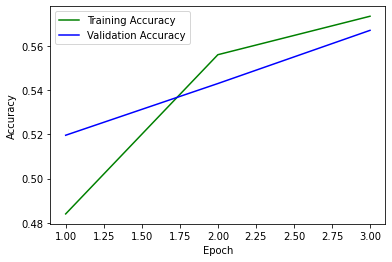

0: 196
1: 3
3: 22
4: 34
Finished generating predictions to predictions_c2_g2.csv


In [24]:
model = get_model(1024, 0.1, 128, 0.1).to(device)
y_hat_test = train_and_test(model, group_2())
predict_whole_images(y_hat_test, 5, 5, 'predictions_c2_g2.csv')

### Train and Test - Group 3

In [116]:
model = get_model(1024, 0.1, 128, 0.1).to(device)
y_hat_test = train_and_test(model, group_3())
predict_whole_images(y_hat_test, 5, 5, 'predictions_c2_g3.csv')

Reading annotations...
Computing class weights...
Epoch 0/0
----------
train 0:00:58.408690 loss: 1.2433 accuracy: 0.5142
Elapsed time: 0:00:58.411297

Training complete in 0m 58s
Best acc: 0.514165
1: 145
4: 55
Finished generating predictions to predictions_c2_g3.csv


## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `d1` - Dropout rate after first classifier dense layer
3. `n2` - Number of neurons in the second classifier dense layer
4. `d2` - Dropout rate after the second classifier dense layer

In [23]:
optimal_n1 = 1024
optimal_d1 = 0.1
optimal_n2 = 128
optimal_d2 = 0.1

## Train with all C2 data and optimal hyperparameters

Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/14
----------
train 0:01:53.807067 loss: 0.9631 accuracy: 0.7624
Elapsed time: 0:01:53.809058

Epoch 1/14
----------
train 0:01:56.021694 loss: 0.9377 accuracy: 0.7722
Elapsed time: 0:01:56.024624

Epoch 2/14
----------
train 0:02:02.128446 loss: 0.8448 accuracy: 0.7879
Elapsed time: 0:02:02.131508

Epoch 3/14
----------
train 0:01:56.126578 loss: 0.8189 accuracy: 0.7926
Elapsed time: 0:01:56.129686

Epoch 4/14
----------
train 0:01:57.667237 loss: 0.7779 accuracy: 0.7921
Elapsed time: 0:01:57.668076

Epoch 5/14
----------
train 0:01:57.476649 loss: 0.7702 accuracy: 0.7973
Elapsed time: 0:01:57.479377

Epoch 6/14
----------
train 0:01:55.408509 loss: 0.8029 accuracy: 0.7988
Elapsed time: 0:01:55.411722

Epoch 7/14
----------
train 0:01:56.534925 loss: 0.7810 accuracy: 0.8099
Elapsed time: 0:01:56.538341

Epoch 8/14
----------
train 0:01:54.804176 loss: 0.7633 accuracy: 0.8025
Elapsed

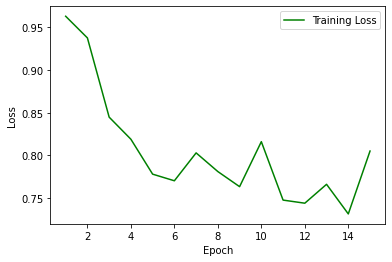

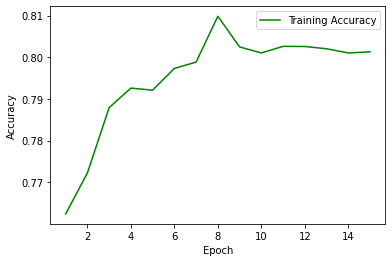

In [40]:
model = get_model(optimal_n1, optimal_d1, optimal_n2, optimal_d2).to(device)
# model.load_state_dict(torch.load('cnn_pytorch_c2.pt'))
y_hat_test = train_and_test(model, group_3(), num_epochs=15)
predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, 'predict_c2_4.csv')

In [36]:
torch.set_printoptions(profile="full")
print(y_hat_test)
torch.set_printoptions(profile="default")

tensor([3, 4, 2, 2, 2, 3, 3, 2, 3, 2, 4, 3, 2, 2, 2, 4, 3, 3, 2, 2, 4, 3, 3, 2,
        2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 2, 2, 4, 4, 3, 2, 3, 4, 4, 4, 3, 3, 4, 4, 3, 3, 2, 4,
        4, 3, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 2, 4, 3, 3, 3, 3, 4, 2,
        4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 3, 2, 4, 3, 4, 3, 2, 3, 3, 3, 4, 2,
        2, 3, 3, 4, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3,
        2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

### Save model

In [41]:
torch.save(model.state_dict(), 'cnn_pytorch_c2.pt')